##Import various python functions and modules that we'll use.

In [4]:
from IPython.display import FileLink

##Load Rmagic extension.

In [2]:
%load_ext rpy2.ipython

##Import R libraries we'll use.

In [3]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(RColorBrewer)
library(scales)

foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com
Loading required package: iterators
Loading required package: parallel
Loading required package: grid


##Import data into R. Prune to relevant samples (PS, non-bulk). Get rid of OTUs not observed in at least 25% of samples).

In [6]:
%%R
physeq = import_biom("../data/otu_table_wtax.biom", "../data/otusn.tree")
sample.data = import_qiime_sample_data("../data/ABCD_combined_reads_mapper.tsv")
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)
physeq.PS = prune_samples((physeq.md$Treatment %in% c("12CCPS","13CCPS","13CXPS"))&
                          !(row.names(physeq.md) %in% grep("bulk", row.names(physeq.md), value=TRUE)), physeq)
physeq.PS.snorm = transform_sample_counts(physeq.PS, function(x) x/sum(x))
physeq.PS.thresh = filter_taxa(physeq.PS.snorm, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)
print(physeq.PS)
print(physeq.PS.thresh)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6236 taxa and 277 samples ]
sample_data() Sample Data:       [ 277 samples by 7 sample variables ]
tax_table()   Taxonomy Table:    [ 6236 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 6236 tips and 6235 internal nodes ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 982 taxa and 277 samples ]
sample_data() Sample Data:       [ 277 samples by 7 sample variables ]
tax_table()   Taxonomy Table:    [ 982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 982 tips and 981 internal nodes ]


###Calculate pairwise weighted unifrac distances between samples.

In [7]:
%%R
registerDoParallel(cores=20)
wunif.dist = distance(physeq.PS.thresh, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

###Ordinate using weighted unifrac distnaces with NMDS.

In [8]:
%%R
nmds = ordinate(physeq.PS.thresh, 
                method = "NMDS", 
                distance = wunif.dist)

Run 0 stress 0.07094327 
Run 1 stress 0.1307669 
Run 2 stress 0.07296645 
Run 3 stress 0.1071013 
Run 4 stress 0.1202694 
Run 5 stress 0.1169076 
Run 6 stress 0.09450736 
Run 7 stress 0.09043557 
Run 8 stress 0.0806265 
Run 9 stress 0.07094315 
... New best solution
... procrustes: rmse 3.046499e-05  max resid 0.0002883654 
*** Solution reached



NULL


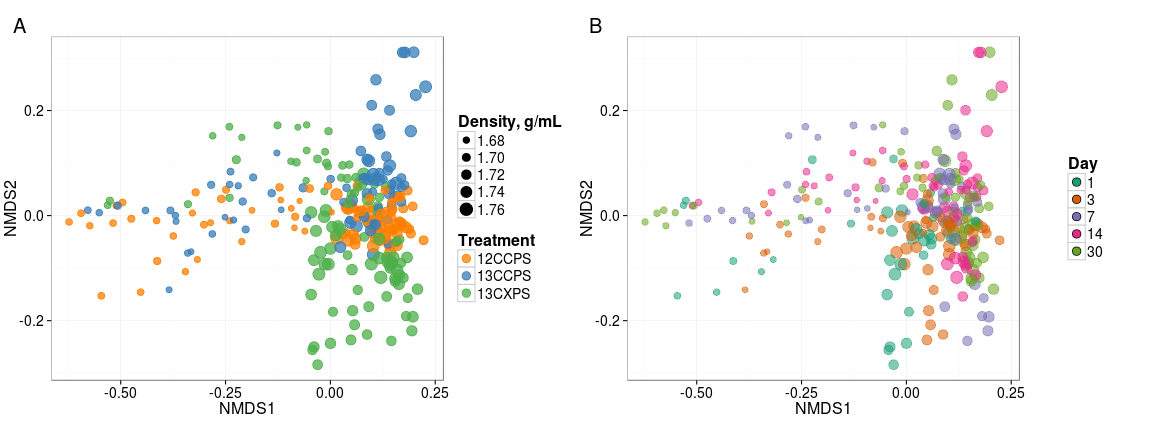

In [24]:
%%R -w 16 -h 6 -u in

colours = c("#ff7f00", "#377eb8", "#4daf4a")

#df = plot_ordination(physeq.PS.thresh, nmds, justDF = TRUE)
df = read.csv("../data/ord_df.csv")
df$Density = as.numeric(as.character(df$Density))

p1 = ggplot(df, aes(x = NMDS1, y = NMDS2)) 
p1 = p1 + geom_point(aes(fill = Treatment, color = Treatment, size = Density), shape=21) 
p1 = p1 + scale_fill_manual(values = alpha(colours, 0.75))
p1 = p1 + scale_color_manual(values = colours)
p1 = p1 + guides(alpha = FALSE)
p1 = p1 + scale_size(range = c(2.5,6))
p1 = p1 + ggtitle("A")
p1 = p1 + guides(fill = guide_legend(override.aes = list(size = 4)))
p1 = p1 + guides(size = guide_legend(override.aes = list(fill = "black")))
p1 = p1 + labs(size = "Density, g/mL")
p1 = p1 + theme_bw()
p1 = p1 + theme(plot.margin = unit(c(1,0,1,0), "lines"))
p1 = p1 + theme(plot.title = element_text(hjust = -0.1, size = 20),
                axis.title = element_text(size = 16),
                axis.text = element_text(size = 14),
                legend.title = element_text(size = 16), 
                legend.text = element_text(size = 14))


p2 = ggplot(df, aes(x = NMDS1, y = NMDS2))
p2 = p2 + geom_point(aes(fill = factor(Day), color = factor(Day), size = Density, alpha = 1.00), shape=21)
p2 = p2 + scale_fill_brewer(palette="Dark2")
p2 = p2 + scale_colour_brewer(palette="Dark2")
p2 = p2 + guides(alpha = FALSE, size = FALSE, color = FALSE)
p2 = p2 + scale_size(range = c(2.5,6))
p2 = p2 + ggtitle("B")
p2 = p2 + guides(fill = guide_legend(title = "Day", override.aes = list(size = 4)))
p2 = p2 + theme_bw()
p2 = p2 + theme(plot.margin = unit(c(1,0,1,0), "lines"))
p2 = p2 + theme(plot.title = element_text(hjust = -0.1, size = 20),
                axis.title = element_text(size = 16),
                axis.text = element_text(size = 14),
                legend.title = element_text(size = 16), 
                legend.text = element_text(size = 14))

gp1 = ggplot_gtable(ggplot_build(p1))
gp2 = ggplot_gtable(ggplot_build(p2))
maxWidth = unit.pmax(gp1$widths[2:5], gp2$widths[2:5])

gp1$widths[2:5] <- maxWidth
gp2$widths[2:5] <- maxWidth

p.combined = grid.arrange(gp1, gp2, ncol = 2)
p.combined

In [25]:
%%R
pdf("figs/ordination_all.pdf", w = 16, h = 6)
grid.arrange(gp1, gp2, ncol = 2)
dev.off()

png 
  2 


In [11]:
FileLink("figs/ordination_all.pdf")

/home/chuck/working/CSIP_succession_data_analysis/figures_and_stats/figs/ordination_all.pdf

In [16]:
%%R
write.csv(df, "../data/ord_df.csv", row.names = FALSE)

In [18]:
FileLink("../data/ord_df.csv")

/home/chuck/working/CSIP_succession_data_analysis/data/ord_df.csv